In [81]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
import matplotlib.colors as colors
from scripts.conversion import *
import pandas as pd

In [10]:
cd ..

/home/rd804/discriminator-metric


In [61]:
tests =[ {'exp_name': 'trial_1_ln_jetnet30',
          'best_epoch': 0,
          'type': 'lorentznet'},
           {'exp_name': 'trial_1_pn_jetnet30',
          'best_epoch': 'best_model_score',
          'type': 'particlenet'},
           {'exp_name': 'trial_1_remove_tail_PN',
          'best_epoch': 'best_model_score',
          'type': 'particlenet'},
           {'exp_name': 'test_cartesian_1',
            'best_epoch': 3,
          'type': 'lorentznet'} ,
          {'exp_name': 'test_3_cartesian_particlenet',
           'best_epoch': 'best_model_score',
           'type': 'particlenet'}]


In [16]:
tests_ln = ['eta_smeared','shifted','smeared','pt_shifted']

jet_test_ln = [
{'exp_name': f'trial_1_ln_{test}',
 'model_score': 'best_model_score'}
 for test  in tests_ln]

In [17]:
tests_pn = ['eta_smeared','shifted','smeared','all_smeared','pt_shifted'
         ,'pt_smeared']

jet_test_pn = [
{'exp_name': f'trial_1_pn_{test}',
 'model_score': 'best_model_score'}
 for test  in tests_pn]


In [8]:

label = pd.read_hdf('data/jetnet30_data.h5', 'labels_valid')['labels'].values
print(label.shape)



(100000,)


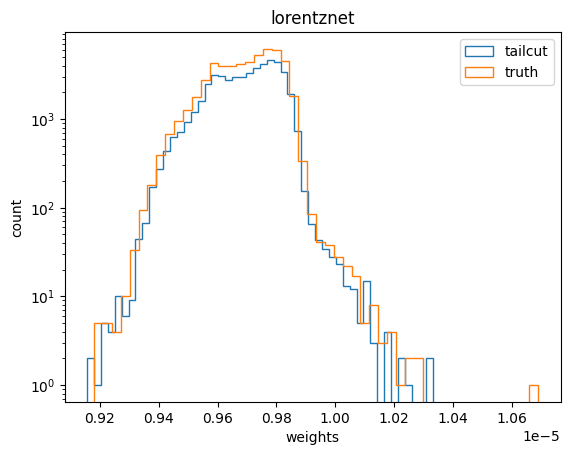

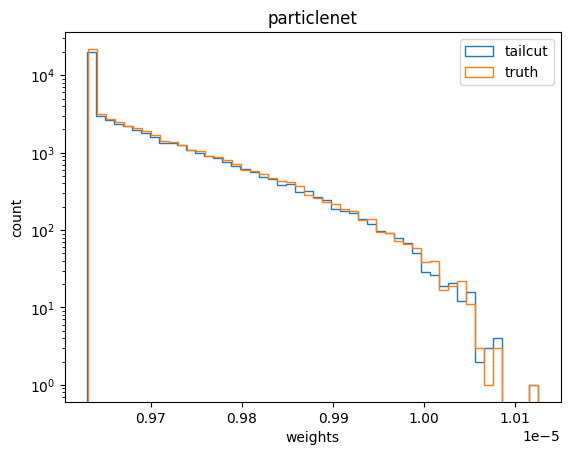

IndexError: boolean index did not match indexed array along dimension 0; dimension is 52158 but corresponding boolean dimension is 103176

In [71]:
for test in tests:
    exp_name = test['exp_name']
    best_epoch = test['best_epoch']
    if test['type']=='lorentznet':
        score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')[:,2]
    elif test['type']=='particlenet':
        score = np.load(f'output/{exp_name}/best_model_score.npy')[:,1]

    weights = score/(1-score)
    weights = weights/np.sum(weights)
    plt.hist(weights[label==0], bins=50,histtype='step', label='tailcut')
    plt.hist(weights[label==1], bins=50,histtype='step', label='truth')
    plt.legend()
    plt.xlabel('weights')
    plt.ylabel('count')
    plt.yscale('log')
    plt.title(test['type'])
    plt.show()


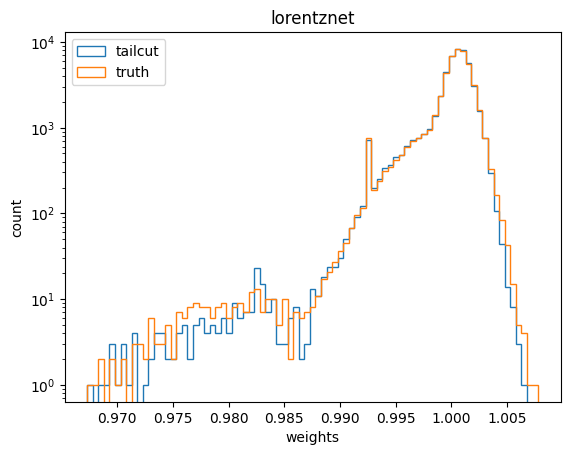

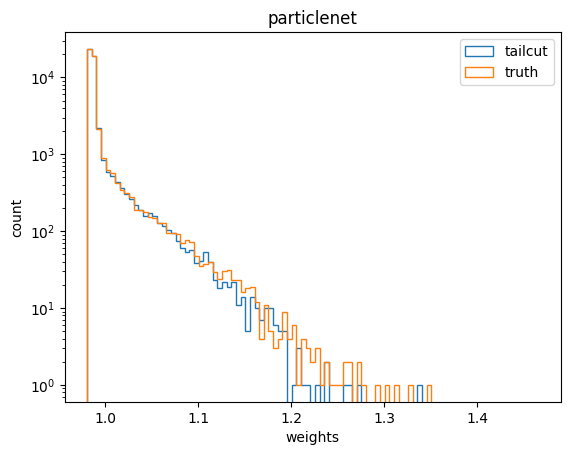

In [63]:
test_1 = [tests[-2],tests[-1]]

for test in test_1:
    exp_name = test['exp_name']
    best_epoch = test['best_epoch']
    if test['type']=='lorentznet':
        score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')
        weights = score[:,2]/(1-score[:,2])
        plt.hist(weights[label==0], 
                 bins=np.arange(min(weights), max(weights),0.0005),
                 histtype='step', label='tailcut')
        plt.hist(weights[label==1], 
                 bins=np.arange(min(weights), max(weights),0.0005),
                 histtype='step', label='truth')
      #  print(np.sum(label-score[:-2,0]))

    elif test['type']=='particlenet':
       # continue
        score = np.load(f'output/{exp_name}/best_model_score.npy')[:,0]
        weights = score/(1-score)
        plt.hist(weights[label==0], bins=np.arange(min(weights), max(weights),0.005),
              histtype='step', label='tailcut')
        plt.hist(weights[label==1], bins=np.arange(min(weights), max(weights),0.005),
                 histtype='step', label='truth')

        



    plt.xlabel('weights')
    plt.ylabel('count')
    plt.yscale('log')
    if test['type']=='lorentznet':
        plt.legend(loc='upper left')
    else:
        plt.legend()
    #plt.xscale('log')
    #plt.xlim(0.,1.4)
    plt.title(test['type'])
    plt.show()

/tmp/ipykernel_4102408/766933591.py:21: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/fpr)
/tmp/ipykernel_4102408/766933591.py:21: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr)
/tmp/ipykernel_4102408/766933591.py:15: RuntimeWarning: divide by zero encountered in divide
  plt.plot(tpr,tpr/fpr)
/tmp/ipykernel_4102408/766933591.py:15: RuntimeWarning: invalid value encountered in divide
  plt.plot(tpr,tpr/fpr)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


100000


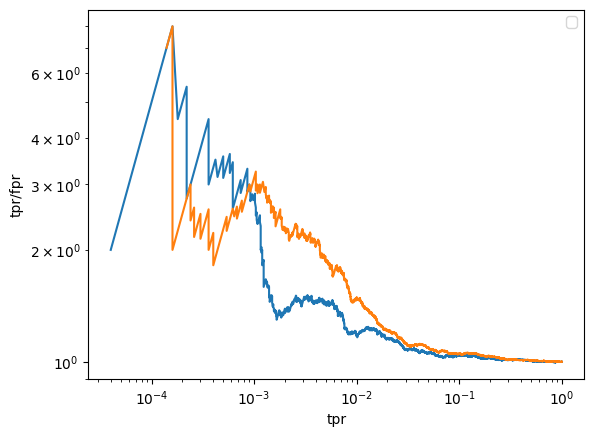

In [101]:
test_1 = [tests[-1],tests[-2]]


for test in test_1:
    exp_name = test['exp_name']
    best_epoch = test['best_epoch']
    if test['type']=='lorentznet':
        score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')[:,2]
        print(len(score))
        #_label = np.load(f'output/{exp_name}/score_{best_epoch}.npy')[:,0]

        auc = roc_auc_score(label, score)
        fpr, tpr, _ = roc_curve(label, score)
       # plt.plot(tpr, 1/fpr, label=f'{test["type"]} AUC={auc:.3f}')
        plt.plot(tpr,tpr/fpr)

    elif test['type']=='particlenet':
        score = np.load(f'output/{exp_name}/best_model_score.npy')[:,0]
        auc = roc_auc_score(label, score)
        fpr, tpr, _ = roc_curve(label, score)
        plt.plot(tpr,tpr/fpr)

        #plt.plot(tpr, 1/fpr, label=f'{test["type"]} AUC={auc:.3f}')

        


#plt.plot(tpr,1, label='random',linestyle='--',color='black')
plt.xlabel('tpr')
plt.ylabel('tpr/fpr')
plt.yscale('log')
plt.legend(loc='upper right')
plt.xscale('log')
#plt.xlim(0.1,10)
#plt.title(test['type'])
plt.show()

In [103]:
(0.503-0.50)/0.50

0.006000000000000005

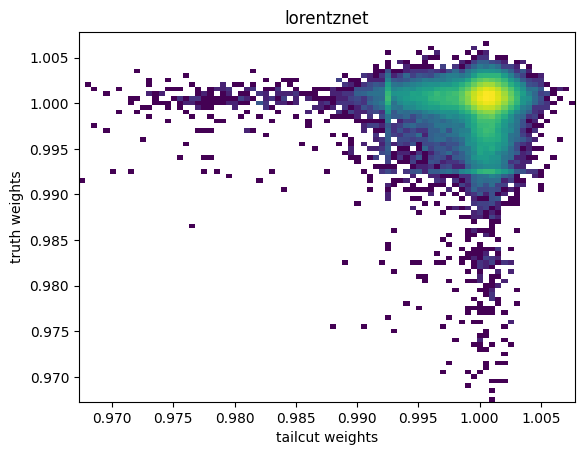

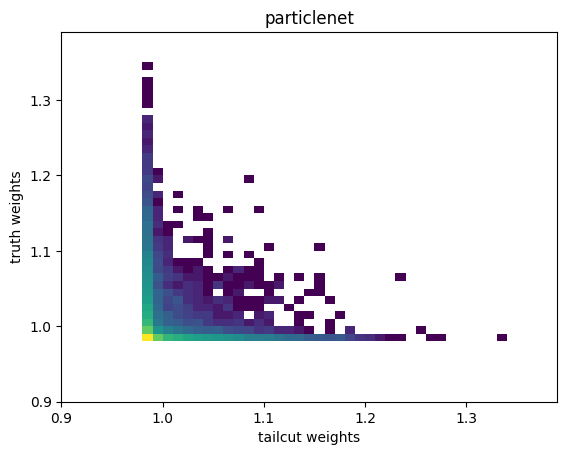

In [141]:
test_1 = [tests[-2],tests[-1]]

for test in test_1:
    exp_name = test['exp_name']
    best_epoch = test['best_epoch']
    if test['type']=='lorentznet':
        score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')
        weights = score[:,2]/(1-score[:,2])
      #  print(len(weights[label==1]))
      #  print(len(weights[label==0]))
        bins = np.arange(min(weights), max(weights),0.0005)
        plt.hist2d(weights[label==1], weights[label==0],
                 bins=[bins,bins], norm = colors.LogNorm())
        
    elif test['type']=='particlenet':
        score = np.load(f'output/{exp_name}/best_model_score.npy')[:,0]
        weights = score/(1-score)
        bins = np.arange(0.9, 1.4,0.01)

        plt.hist2d(weights[label==0],weights[label==1], 
                   bins=[bins,bins], norm = colors.LogNorm())


        



    plt.xlabel('tailcut weights')
    plt.ylabel('truth weights')
    #plt.yscale('log')
    #if test['type']=='lorentznet':
    #    plt.legend(loc='upper left')
   # else:
    #    plt.legend()
    #plt.xscale('log')
    #plt.xlim(0.,1.4)
    plt.title(test['type'])
    plt.show()

(100000, 2)
100000


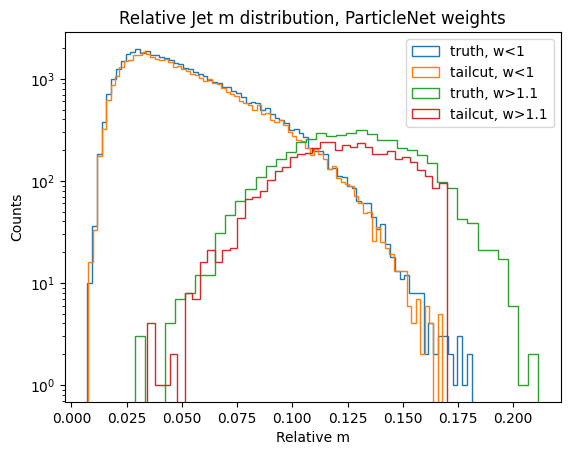

In [96]:
s = 'valid'
test_ = tests[-1]
exp_name = test_['exp_name']
#best_epoch = 3

data = pd.read_hdf('data/jetnet30_data.h5', f'particle_data_{s}').values.reshape(-1,30,4)
labels = pd.read_hdf('data/jetnet30_data.h5', f'labels_{s}')['labels'].values
score = np.load(f'output/{exp_name}/best_model_score.npy')
print(score.shape)
weights = score[:,0]/(1-score[:,0])
print(len(score))

#labels = f[f'labels_{s}']
#pt = pt_jets(data)
m = mjj_jets(data)
#assert len(data) == len(labels)
density = False
figure = plt.figure()
plt.hist(m[(labels==1) & (weights < 1) ], bins=80, 
                histtype='step', label='truth, w<1',density=density)
plt.hist(m[(labels==0) & (weights < 1) ], bins=80, 
                histtype='step', label='tailcut, w<1',density=density)
plt.hist(m[(labels==1) & (weights > 1.) ], bins=40, 
                histtype='step', label='truth, w>1.1',density=density)
plt.hist(m[(labels==0) & (weights > 1.) ], bins=40, 
                histtype='step', label='tailcut, w>1.1',density=density)

#plt.hist(m[(labels==1) & (weights < 0.997) ], bins=100, 
 #               histtype='step', label='label 1, w<0.997',density=True)
#plt.hist(m[labels==1], bins=100, 
 #               histtype='step', label='label 1', density=True)
plt.legend()
plt.xlabel('Relative m')
if density:
    plt.ylabel('Normalized counts')
else:
    plt.ylabel('Counts')
plt.yscale('log')
plt.title(f'Relative Jet m distribution, ParticleNet weights')
plt.show()



In [84]:
accuracy = accuracy_score(label, score[:,0]>0.5)
print(accuracy)

0.50163


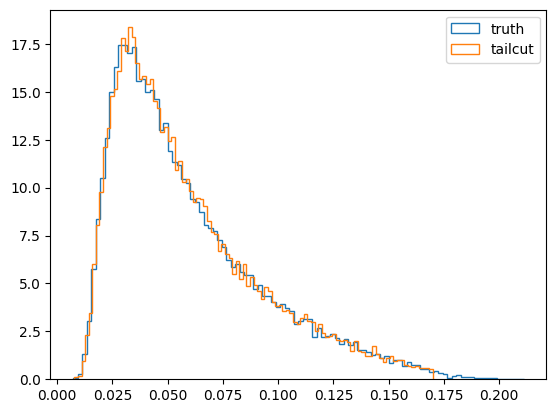

In [89]:
s = 'valid'
data = pd.read_hdf('data/jetnet30_data.h5', f'particle_data_{s}').values.reshape(-1,30,4)
labels = pd.read_hdf('data/jetnet30_data.h5', f'labels_{s}')['labels'].values

m = mjj_jets(data)

plt.hist(m[labels==1], bins=100,histtype='step', label='truth',density=True)
plt.hist(m[labels==0], bins=100, histtype='step', label='tailcut',density=True)
plt.legend()
plt.show()


In [94]:
#auc = roc_auc_score(label, )
#print(auc)



0.49755


50000

100000


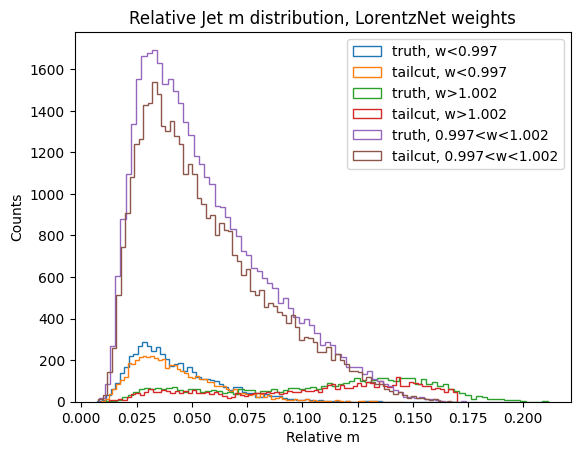

In [95]:
s = 'valid'
exp_name = 'test_cartesian_1'
best_epoch = 3
data = pd.read_hdf('data/jetnet30_data.h5', f'particle_data_{s}').values.reshape(-1,30,4)
labels = pd.read_hdf('data/jetnet30_data.h5', f'labels_{s}')['labels'].values
score = np.load(f'output/{exp_name}/score_{best_epoch}.npy')[:,2]

weights = score/(1-score)
print(len(score))

#labels = f[f'labels_{s}']
#pt = pt_jets(data)
m = mjj_jets(data)
#assert len(data) == len(labels)
density = False
figure = plt.figure()
plt.hist(m[(labels==1) & (weights < 0.997) ], bins=80, 
                histtype='step', label='truth, w<0.997',density=density)
plt.hist(m[(labels==0) & (weights < 0.997) ], bins=80, 
                histtype='step', label='tailcut, w<0.997',density=density)
plt.hist(m[(labels==1) & (weights > 1.002) ], bins=80, 
                histtype='step', label='truth, w>1.002',density=density)
plt.hist(m[(labels==0) & (weights > 1.002) ], bins=80, 
                histtype='step', label='tailcut, w>1.002',density=density)
plt.hist(m[(labels==1) & (weights < 1.002) & (weights > 0.997) ], bins=80, 
                histtype='step', label='truth, 0.997<w<1.002',density=density)

plt.hist(m[(labels==0) & (weights < 1.002) & (weights > 0.997) ], bins=80, 
                histtype='step', label='tailcut, 0.997<w<1.002',density=density)


#plt.hist(m[(labels==1) & (weights < 0.997) ], bins=100, 
 #               histtype='step', label='label 1, w<0.997',density=True)
#plt.hist(m[labels==1], bins=100, 
 #               histtype='step', label='label 1', density=True)
plt.legend()
plt.xlabel('Relative m')
if density:
    plt.ylabel('Normalized counts')
else:
    plt.ylabel('Counts')
plt.title(f'Relative Jet m distribution, LorentzNet weights')
plt.show()



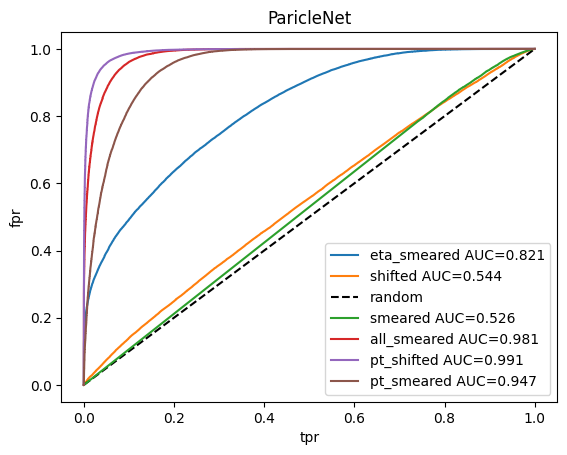

In [49]:
s = 'valid'
for i,test in enumerate(tests_pn):
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values
    exp_name = jet_test_pn [i]['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')
    assert len(score) == len(label)
    auc = roc_auc_score(label, score[:,0])
    tpr, fpr, _ = roc_curve(label, score[:,0])
    plt.plot(tpr, fpr, label=f'{test} AUC={auc:.3f}')
    if i==1:
        plt.plot(tpr,tpr, label='random',linestyle='--',color='black')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('ParicleNet')
#plt.yscale('log')
plt.legend(loc='lower right')
plt.show()

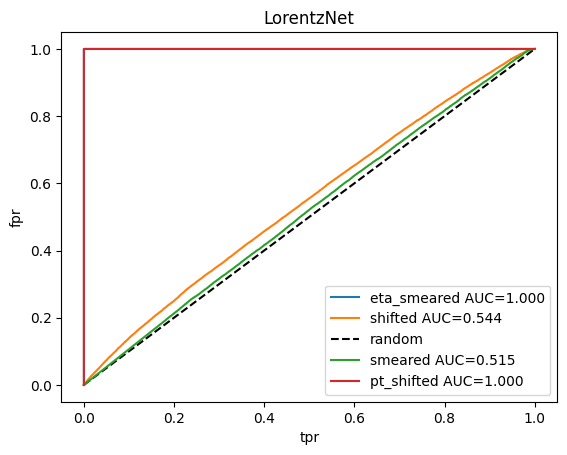

In [43]:
s = 'valid'
for i,test in enumerate(tests_ln):
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values
    exp_name = jet_test_ln [i]['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')
    assert len(score) == len(label)
    #print(score.shape)
    auc = roc_auc_score(label, score)
    tpr, fpr, _ = roc_curve(label, score)
    plt.plot(tpr, fpr, label=f'{test} AUC={auc:.3f}')
    if i==1:
        plt.plot(tpr,tpr, label='random',linestyle='--',color='black')
plt.xlabel('tpr')
plt.ylabel('fpr')
plt.title('LorentzNet')
#plt.yscale('log')
plt.legend(loc='lower right')
plt.show()
    #print(f'{auc} for distortion {test}, for LorentzNet')

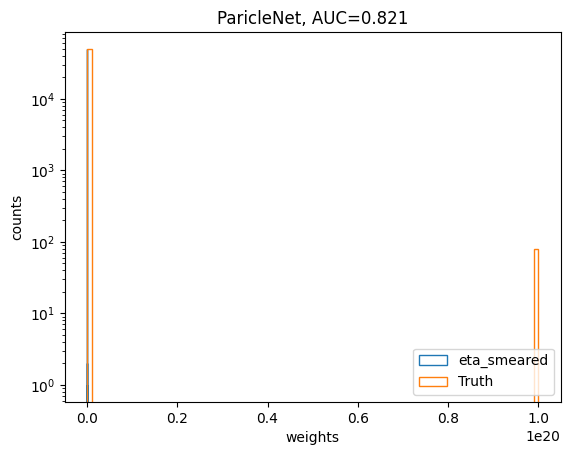

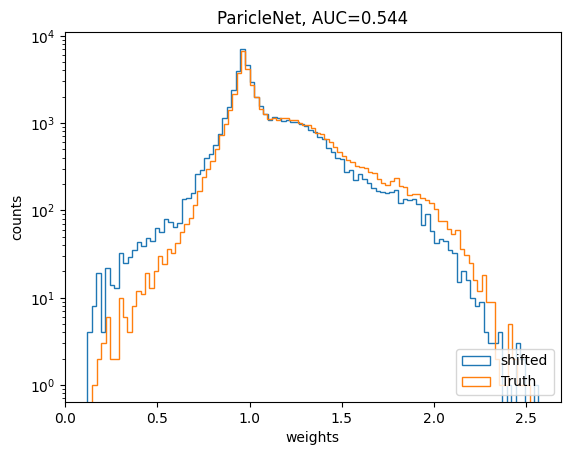

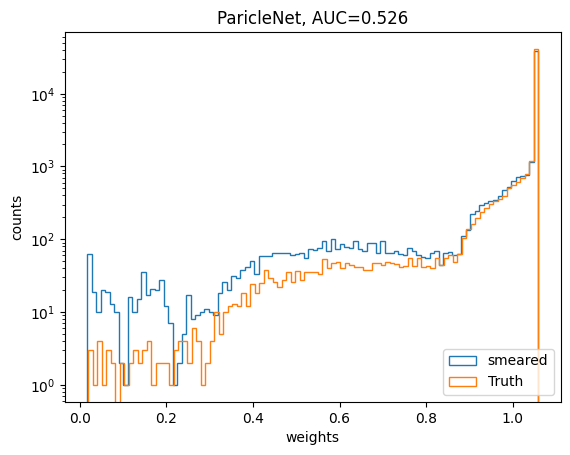

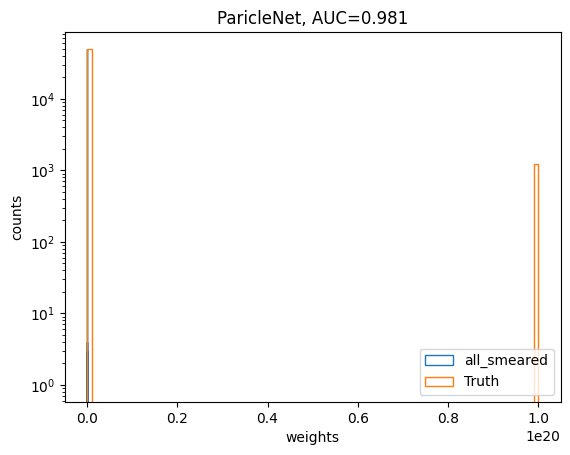

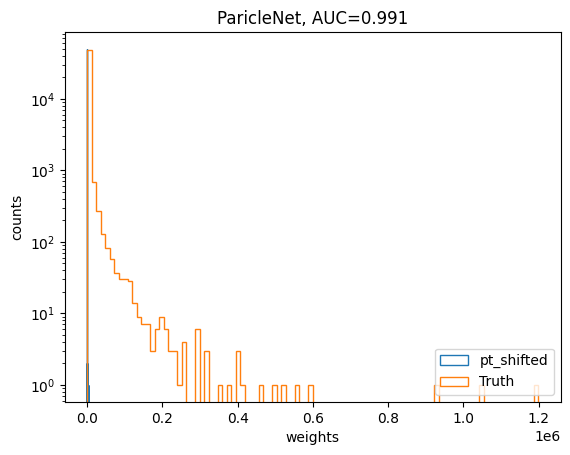

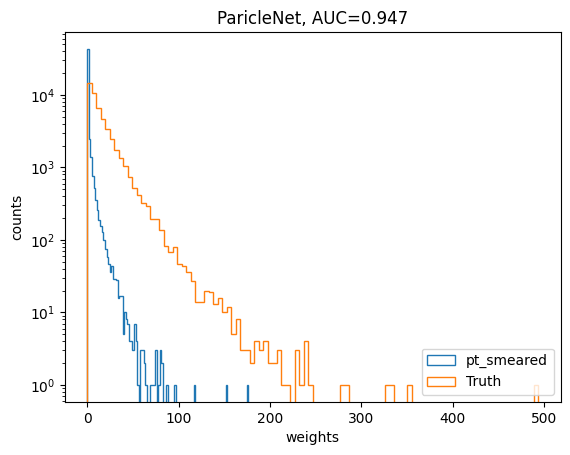

In [56]:
s = 'valid'
for i,test in enumerate(tests_pn):
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values
    exp_name = jet_test_pn[i]['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')
    weights = score[:,0]/(1-score[:,0]+1e-20)
    assert len(score) == len(label)
    auc = roc_auc_score(label, score[:,0])
   # tpr, fpr, _ = roc_curve(label, score[:,0])
    plt.hist(weights[label==0], label=f'{test}',bins=100, histtype='step')
    plt.hist(weights[label==1], label='Truth',bins=100, histtype='step')

    plt.xlabel('weights')
    plt.ylabel('counts')
    plt.title(f'ParicleNet, AUC={auc:.3f}')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.show()

/tmp/ipykernel_4102408/1180970976.py:6: RuntimeWarning: divide by zero encountered in divide
  weights = score/(1-score)


ValueError: supplied range of [104856.6015625, inf] is not finite

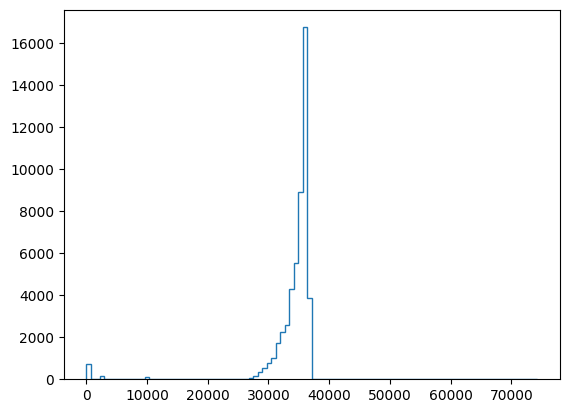

In [59]:
s = 'valid'
for i,test in enumerate(tests_ln):
    label = pd.read_hdf('data/jetnet30_data.h5', f'labels__{test}_{s}')['labels'].values
    exp_name = jet_test_ln[i]['exp_name']
    score = np.load(f'output/{exp_name}/best_model_score.npy')
    weights = score/(1-score)
    assert len(score) == len(label)
    auc = roc_auc_score(label, score)
   # tpr, fpr, _ = roc_curve(label, score[:,0])
    plt.hist(weights[label==0], label=f'{test}',bins=100, histtype='step')
    plt.hist(weights[label==1], label='Truth',bins=100, histtype='step')

    plt.xlabel('weights')
    plt.ylabel('counts')
    plt.title(f'ParicleNet, AUC={auc:.3f}')
    plt.yscale('log')
    plt.legend(loc='lower right')
    plt.show()